In [ ]:
from PIL import Image
import os

data_dir = 'cats_vs_dogs'

for category in ['cats', 'dogs']:
    category_path = os.path.join(data_dir, category)
    for filename in os.listdir(category_path):
        file_path = os.path.join(category_path, filename)
        try:
            with Image.open(file_path) as img:
                rgb_img = img.convert('RGB')  
                new_filename = os.path.splitext(filename)[0] + '.jpg'
                rgb_img.save(os.path.join(category_path, new_filename), 'JPEG')
                if filename != new_filename:
                    os.remove(file_path)  
        except Exception as e:
            print(f"Error processing {file_path}: {e}")


Found 17 files belonging to 2 classes.
Using 14 files for training.
Found 17 files belonging to 2 classes.
Using 3 files for validation.

Training L2 Regularization...
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.4286 - loss: 15.4388 - val_accuracy: 0.3333 - val_loss: 1939.8073
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5714 - loss: 1220.5292 - val_accuracy: 0.3333 - val_loss: 584.2546
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5714 - loss: 354.0935 - val_accuracy: 0.6667 - val_loss: 88.4946
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4286 - loss: 93.5950 - val_accuracy: 0.6667 - val_loss: 44.9907
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4286 - loss: 49.2033 - val_accuracy: 0.3333 - val_loss: 18.9885

Training Dropout...
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.5000 - loss: 13.0854 - val_accuracy: 0.6667 - val_loss: 422.3620
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy

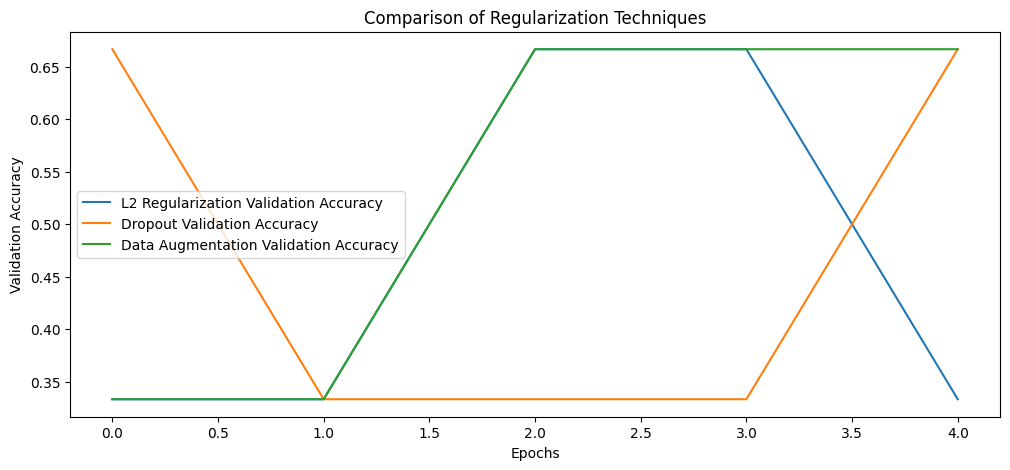

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import os

data_dir = 'cats_vs_dogs' 

def convert_and_preprocess(image, label):
    image = tf.image.resize(image, (128, 128))
    image = tf.image.convert_image_dtype(image, tf.float32)  
    return image, label

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

train_data = train_data.map(convert_and_preprocess)
test_data = test_data.map(convert_and_preprocess)

def build_model(regularization=None, dropout_rate=0.0, data_augmentation=False):
    model = models.Sequential()
    
    if data_augmentation:
        model.add(layers.RandomFlip('horizontal'))
        model.add(layers.RandomRotation(0.1))
        model.add(layers.RandomZoom(0.1))
        
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3),
                            kernel_regularizer=regularization))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularization))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularization))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularization))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models_info = {
    'L2 Regularization': build_model(regularization=regularizers.l2(0.01)),
    'Dropout': build_model(dropout_rate=0.5),
    'Data Augmentation': build_model(data_augmentation=True)
}

histories = {}
for name, model in models_info.items():
    print(f"\nTraining {name}...")
    history = model.fit(train_data, validation_data=test_data, epochs=5, verbose=1)
    histories[name] = history

plt.figure(figsize=(12, 5))
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{name} Validation Accuracy')
plt.title('Comparison of Regularization Techniques')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()
